# SVM HOG Resolution Comparison

This notebook tests different image resolutions to find the optimal size for SVM with HOG features.

**Resolutions to test:**
- 24x24 (small, fast)
- 48x48 (medium-small)
- 64x64 (medium, currently used)
- 128x128 (large, more detail)

**What we do:**
1. Generate HOG features for each resolution
2. Train SVM with GridSearchCV for each
3. Compare accuracy, training time, and feature dimensions
4. Visualize results to identify the best resolution

## 1. Import Libraries

In [1]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Setup Paths

In [2]:
# Define dataset paths
BASE_PATH = '/media/ubuntu/NVME/AIML project/AlphaNum2'
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")
TRAIN_PATH = "/media/ubuntu/NVME/AIML project/AlphaNum/results/outputs/Brightness_Both"
# Define output directory
RESULTS_PATH = '/media/ubuntu/NVME/AIML project/AlphaNum2results/SVMhog/resolution_comparison'
os.makedirs(RESULTS_PATH, exist_ok=True)

# Print paths
print(f"Train path: {TRAIN_PATH}")
print(f"Validation path: {VALIDATION_PATH}")
print(f"Test path: {TEST_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")

Train path: /media/ubuntu/NVME/AIML project/AlphaNum/results/outputs/Brightness_Both
Validation path: /media/ubuntu/NVME/AIML project/AlphaNum2/validation
Test path: /media/ubuntu/NVME/AIML project/AlphaNum2/test
Results will be saved to: /media/ubuntu/NVME/AIML project/AlphaNum2results/SVMhog/resolution_comparison


## 3. Define Resolutions to Test

In [3]:
# Define resolutions and corresponding HOG parameters
RESOLUTIONS = {
    '24x24': {
        'size': (24, 24),
        'hog_params': {
            'winSize': (24, 24),
            'blockSize': (8, 8),
            'blockStride': (4, 4),
            'cellSize': (4, 4),
            'nbins': 9
        }
    },
    '48x48': {
        'size': (48, 48),
        'hog_params': {
            'winSize': (48, 48),
            'blockSize': (16, 16),
            'blockStride': (8, 8),
            'cellSize': (8, 8),
            'nbins': 9
        }
    },
    '64x64': {
        'size': (64, 64),
        'hog_params': {
            'winSize': (64, 64),
            'blockSize': (16, 16),
            'blockStride': (8, 8),
            'cellSize': (8, 8),
            'nbins': 9
        }
    },
    '128x128': {
        'size': (128, 128),
        'hog_params': {
            'winSize': (128, 128),
            'blockSize': (16, 16),
            'blockStride': (8, 8),
            'cellSize': (8, 8),
            'nbins': 9
        }
    }
}

print("Resolutions to test:")
for res_name, res_info in RESOLUTIONS.items():
    print(f"  - {res_name}: {res_info['size']}")

Resolutions to test:
  - 24x24: (24, 24)
  - 48x48: (48, 48)
  - 64x64: (64, 64)
  - 128x128: (128, 128)


## 4. HOG Feature Extraction Function

In [4]:
def extract_hog_features_for_resolution(directory_path, resolution_name, resolution_config, max_samples_per_class=None):
    """
    Extract HOG features from all images in a directory for a specific resolution.
    
    Args:
        directory_path: Path to directory containing image subdirectories (classes)
        resolution_name: Name of resolution (e.g., '64x64')
        resolution_config: Dictionary with 'size' and 'hog_params'
        max_samples_per_class: Maximum samples per class (None for all)
        
    Returns:
        features: NumPy array of HOG features
        labels: NumPy array of string labels
    """
    features = []
    labels = []
    
    # Get resolution info
    img_size = resolution_config['size']
    hog_params = resolution_config['hog_params']
    
    # Initialize HOG descriptor
    hog = cv2.HOGDescriptor(
        _winSize=hog_params['winSize'],
        _blockSize=hog_params['blockSize'],
        _blockStride=hog_params['blockStride'],
        _cellSize=hog_params['cellSize'],
        _nbins=hog_params['nbins']
    )
    
    total_images = 0
    
    # Loop through each class folder
    for class_name in sorted(os.listdir(directory_path)):
        class_path = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Skip invalid '999' class
        if class_name == '999':
            continue
        
        class_count = 0
        
        # Loop through each image in the class folder
        for image_name in os.listdir(class_path):
            # Check max samples limit
            if max_samples_per_class and class_count >= max_samples_per_class:
                break
            
            image_path = os.path.join(class_path, image_name)
            
            # Load image in grayscale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Resize to target resolution
                resized_image = cv2.resize(image, img_size)
                
                # Compute HOG features
                hog_features = hog.compute(resized_image)
                
                if hog_features is not None:
                    # Flatten and store features
                    features.append(hog_features.flatten())
                    labels.append(class_name)
                    total_images += 1
                    class_count += 1
    
    print(f"  ✓ {resolution_name}: Processed {total_images} images from {os.path.basename(directory_path)}")
    return np.array(features), np.array(labels)

print("✓ HOG extraction function defined")

✓ HOG extraction function defined


## 5. Extract HOG Features for All Resolutions

**Note:** This will take some time. We'll use a subset of data for faster testing.

In [5]:
# Option: Limit samples per class for faster testing (set to None to use all data)
MAX_SAMPLES_PER_CLASS = 100  # Use 100 samples per class for speed, set to None for full dataset

# Store all extracted features
all_data = {}

print("\n" + "="*80)
print("EXTRACTING HOG FEATURES FOR ALL RESOLUTIONS")
print("="*80)

for res_name, res_config in RESOLUTIONS.items():
    print(f"\n📊 Processing resolution: {res_name}")
    print("-" * 80)
    
    start_time = time.time()
    
    # Extract features for train, validation, and test sets
    train_features, train_labels = extract_hog_features_for_resolution(
        TRAIN_PATH, res_name, res_config, MAX_SAMPLES_PER_CLASS
    )
    
    validation_features, validation_labels = extract_hog_features_for_resolution(
        VALIDATION_PATH, res_name, res_config, MAX_SAMPLES_PER_CLASS
    )
    
    test_features, test_labels = extract_hog_features_for_resolution(
        TEST_PATH, res_name, res_config, MAX_SAMPLES_PER_CLASS
    )
    
    # Convert labels to integers
    train_labels_int = np.array([int(label) for label in train_labels], dtype=np.int32)
    validation_labels_int = np.array([int(label) for label in validation_labels], dtype=np.int32)
    test_labels_int = np.array([int(label) for label in test_labels], dtype=np.int32)
    
    extraction_time = time.time() - start_time
    
    # Store data
    all_data[res_name] = {
        'train_features': train_features,
        'train_labels': train_labels_int,
        'validation_features': validation_features,
        'validation_labels': validation_labels_int,
        'test_features': test_features,
        'test_labels': test_labels_int,
        'feature_dim': train_features.shape[1],
        'extraction_time': extraction_time
    }
    
    print(f"  Feature dimension: {train_features.shape[1]}")
    print(f"  Extraction time: {extraction_time:.2f} seconds")
    print(f"  Train samples: {len(train_features)}")
    print(f"  Validation samples: {len(validation_features)}")
    print(f"  Test samples: {len(test_features)}")

print("\n" + "="*80)
print("✓ HOG FEATURE EXTRACTION COMPLETE")
print("="*80)


EXTRACTING HOG FEATURES FOR ALL RESOLUTIONS

📊 Processing resolution: 24x24
--------------------------------------------------------------------------------
  ✓ 24x24: Processed 5200 images from Brightness_Both
  ✓ 24x24: Processed 5200 images from Brightness_Both
  ✓ 24x24: Processed 4694 images from validation
  ✓ 24x24: Processed 4694 images from validation
  ✓ 24x24: Processed 5162 images from test
  Feature dimension: 900
  Extraction time: 1.49 seconds
  Train samples: 5200
  Validation samples: 4694
  Test samples: 5162

📊 Processing resolution: 48x48
--------------------------------------------------------------------------------
  ✓ 24x24: Processed 5162 images from test
  Feature dimension: 900
  Extraction time: 1.49 seconds
  Train samples: 5200
  Validation samples: 4694
  Test samples: 5162

📊 Processing resolution: 48x48
--------------------------------------------------------------------------------
  ✓ 48x48: Processed 5200 images from Brightness_Both
  ✓ 48x48: Proce

## 6. Train SVM for Each Resolution

Use GridSearchCV to find optimal hyperparameters for each resolution.

In [6]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],              # Regularization parameter
    'kernel': ['linear', 'rbf'],     # Kernel type
    'gamma': ['scale', 'auto']       # Kernel coefficient
}

# Store results
results = []

print("\n" + "="*80)
print("TRAINING SVM FOR ALL RESOLUTIONS")
print("="*80)

for res_name in RESOLUTIONS.keys():
    print(f"\n🎯 Training SVM for resolution: {res_name}")
    print("-" * 80)
    
    # Get data
    data = all_data[res_name]
    train_features = data['train_features']
    train_labels = data['train_labels']
    validation_features = data['validation_features']
    validation_labels = data['validation_labels']
    test_features = data['test_features']
    test_labels = data['test_labels']
    
    # GridSearchCV
    print("  Running GridSearchCV...")
    grid_start = time.time()
    grid_search = GridSearchCV(
        SVC(),
        param_grid,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(train_features, train_labels)
    grid_time = time.time() - grid_start
    
    best_params = grid_search.best_params_
    print(f"  ✓ Best parameters: {best_params}")
    print(f"  ✓ GridSearchCV time: {grid_time:.2f} seconds")
    
    # Train final model with best parameters
    print("  Training final model...")
    train_start = time.time()
    model = SVC(**best_params)
    model.fit(train_features, train_labels)
    train_time = time.time() - train_start
    
    # Evaluate
    train_accuracy = model.score(train_features, train_labels)
    validation_accuracy = model.score(validation_features, validation_labels)
    test_accuracy = model.score(test_features, test_labels)
    
    print(f"  ✓ Training time: {train_time:.2f} seconds")
    print(f"  ✓ Train accuracy: {train_accuracy*100:.2f}%")
    print(f"  ✓ Validation accuracy: {validation_accuracy*100:.2f}%")
    print(f"  ✓ Test accuracy: {test_accuracy*100:.2f}%")
    
    # Save model
    model_path = os.path.join(RESULTS_PATH, f'svm_model_{res_name}.joblib')
    joblib.dump(model, model_path)
    print(f"  ✓ Model saved to: {model_path}")
    
    # Store results
    results.append({
        'resolution': res_name,
        'feature_dim': data['feature_dim'],
        'extraction_time': data['extraction_time'],
        'grid_search_time': grid_time,
        'training_time': train_time,
        'total_time': data['extraction_time'] + grid_time + train_time,
        'best_params': best_params,
        'train_accuracy': train_accuracy,
        'validation_accuracy': validation_accuracy,
        'test_accuracy': test_accuracy,
        'model': model
    })

print("\n" + "="*80)
print("✓ SVM TRAINING COMPLETE FOR ALL RESOLUTIONS")
print("="*80)


TRAINING SVM FOR ALL RESOLUTIONS

🎯 Training SVM for resolution: 24x24
--------------------------------------------------------------------------------
  Running GridSearchCV...
  ✓ Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  ✓ GridSearchCV time: 48.68 seconds
  Training final model...
  ✓ Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  ✓ GridSearchCV time: 48.68 seconds
  Training final model...
  ✓ Training time: 5.45 seconds
  ✓ Train accuracy: 99.90%
  ✓ Validation accuracy: 73.97%
  ✓ Test accuracy: 72.86%
  ✓ Model saved to: /media/ubuntu/NVME/AIML project/AlphaNum2results/SVMhog/resolution_comparison/svm_model_24x24.joblib

🎯 Training SVM for resolution: 48x48
--------------------------------------------------------------------------------
  Running GridSearchCV...
  ✓ Training time: 5.45 seconds
  ✓ Train accuracy: 99.90%
  ✓ Validation accuracy: 73.97%
  ✓ Test accuracy: 72.86%
  ✓ Model saved to: /media/ubuntu/NVME/AIML project/AlphaNum2re

## 7. Results Summary Table

In [7]:
# Create results DataFrame
results_df = pd.DataFrame([
    {
        'Resolution': r['resolution'],
        'Feature Dim': r['feature_dim'],
        'Train Acc (%)': f"{r['train_accuracy']*100:.2f}",
        'Val Acc (%)': f"{r['validation_accuracy']*100:.2f}",
        'Test Acc (%)': f"{r['test_accuracy']*100:.2f}",
        'Total Time (s)': f"{r['total_time']:.2f}",
        'Best Kernel': r['best_params']['kernel'],
        'Best C': r['best_params']['C']
    }
    for r in results
])

print("\n" + "="*100)
print("RESULTS SUMMARY")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save to CSV
csv_path = os.path.join(RESULTS_PATH, 'resolution_comparison_results.csv')
results_df.to_csv(csv_path, index=False)
print(f"\n✓ Results saved to: {csv_path}")


RESULTS SUMMARY
Resolution  Feature Dim Train Acc (%) Val Acc (%) Test Acc (%) Total Time (s) Best Kernel  Best C
     24x24          900         99.90       73.97        72.86          55.62         rbf    10.0
     48x48          900         99.92       75.12        73.89          53.65         rbf    10.0
     64x64         1764         99.94       73.97        73.05         113.27         rbf    10.0
   128x128         8100         99.83       68.19        66.41        1305.11      linear     0.1

✓ Results saved to: /media/ubuntu/NVME/AIML project/AlphaNum2results/SVMhog/resolution_comparison/resolution_comparison_results.csv
Resolution  Feature Dim Train Acc (%) Val Acc (%) Test Acc (%) Total Time (s) Best Kernel  Best C
     24x24          900         99.90       73.97        72.86          55.62         rbf    10.0
     48x48          900         99.92       75.12        73.89          53.65         rbf    10.0
     64x64         1764         99.94       73.97        73.05    

## 8. Visualize Results - Accuracy Comparison

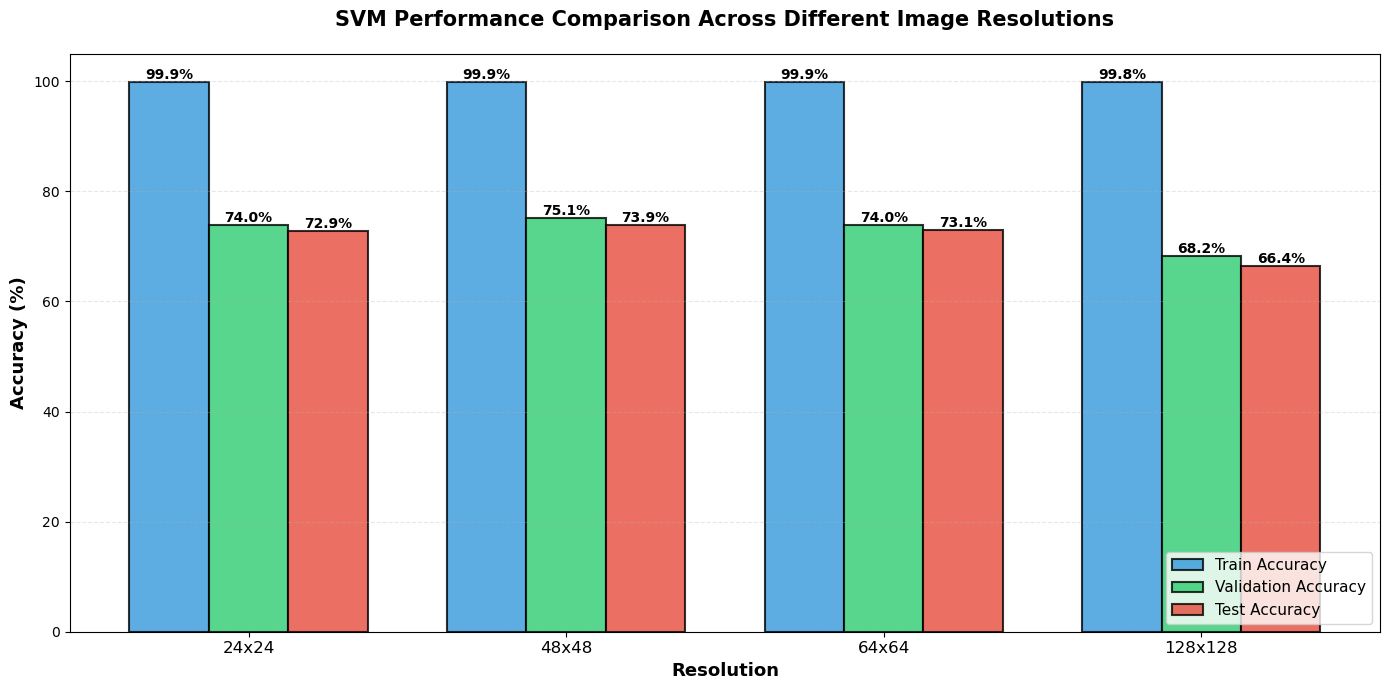

✓ Accuracy comparison chart saved


In [8]:
# Extract data for plotting
resolutions = [r['resolution'] for r in results]
train_accs = [r['train_accuracy'] * 100 for r in results]
val_accs = [r['validation_accuracy'] * 100 for r in results]
test_accs = [r['test_accuracy'] * 100 for r in results]

# Create bar chart
x = np.arange(len(resolutions))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

bars1 = ax.bar(x - width, train_accs, width, label='Train Accuracy', 
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x, val_accs, width, label='Validation Accuracy', 
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars3 = ax.bar(x + width, test_accs, width, label='Test Accuracy', 
               color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Customize chart
ax.set_xlabel('Resolution', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('SVM Performance Comparison Across Different Image Resolutions', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(resolutions, fontsize=12)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'accuracy_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Accuracy comparison chart saved")

## 9. Visualize Results - Time Comparison

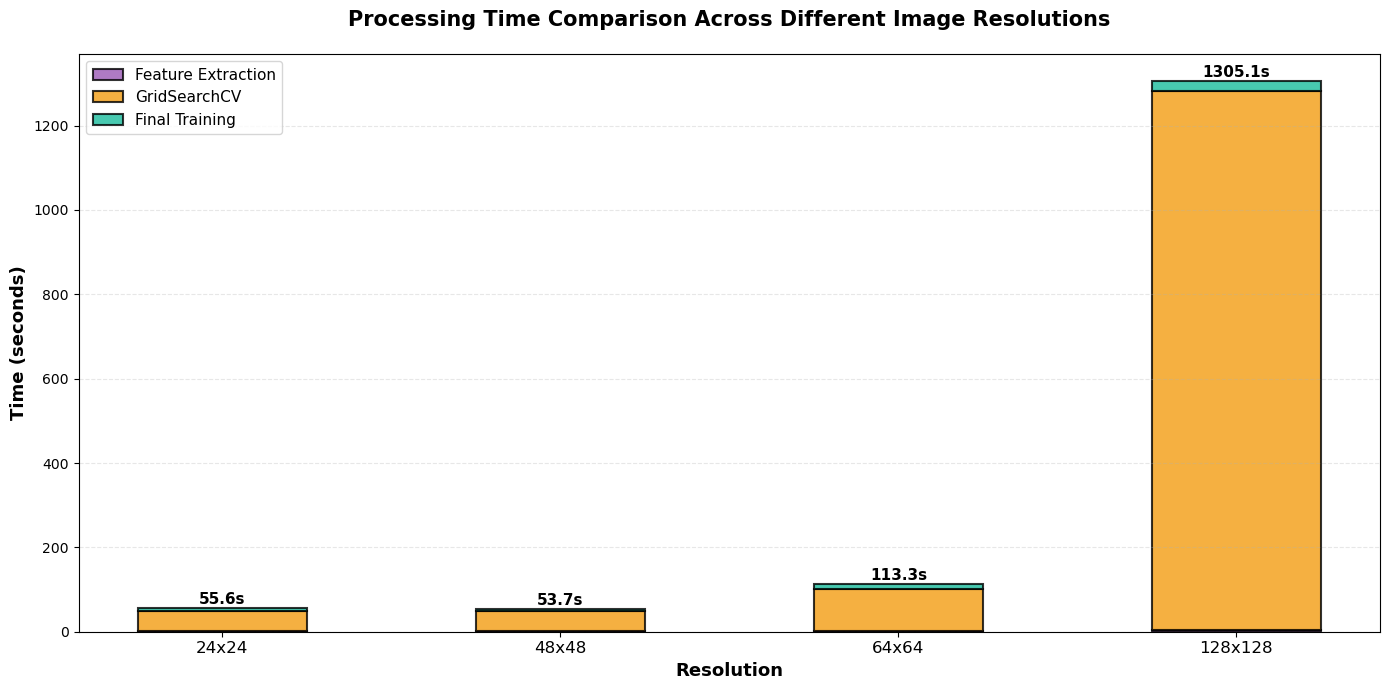

✓ Time comparison chart saved


In [9]:
# Extract timing data
extraction_times = [r['extraction_time'] for r in results]
training_times = [r['training_time'] for r in results]
grid_search_times = [r['grid_search_time'] for r in results]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(resolutions))
width = 0.5

p1 = ax.bar(x, extraction_times, width, label='Feature Extraction', 
            color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.5)
p2 = ax.bar(x, grid_search_times, width, bottom=extraction_times, 
            label='GridSearchCV', color='#f39c12', alpha=0.8, edgecolor='black', linewidth=1.5)
p3 = ax.bar(x, training_times, width, 
            bottom=np.array(extraction_times) + np.array(grid_search_times),
            label='Final Training', color='#1abc9c', alpha=0.8, edgecolor='black', linewidth=1.5)

# Add total time labels
total_times = [r['total_time'] for r in results]
for i, total in enumerate(total_times):
    ax.text(i, total + 2, f'{total:.1f}s', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

# Customize chart
ax.set_xlabel('Resolution', fontsize=13, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Processing Time Comparison Across Different Image Resolutions', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(resolutions, fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'time_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Time comparison chart saved")

## 10. Visualize Results - Feature Dimensions

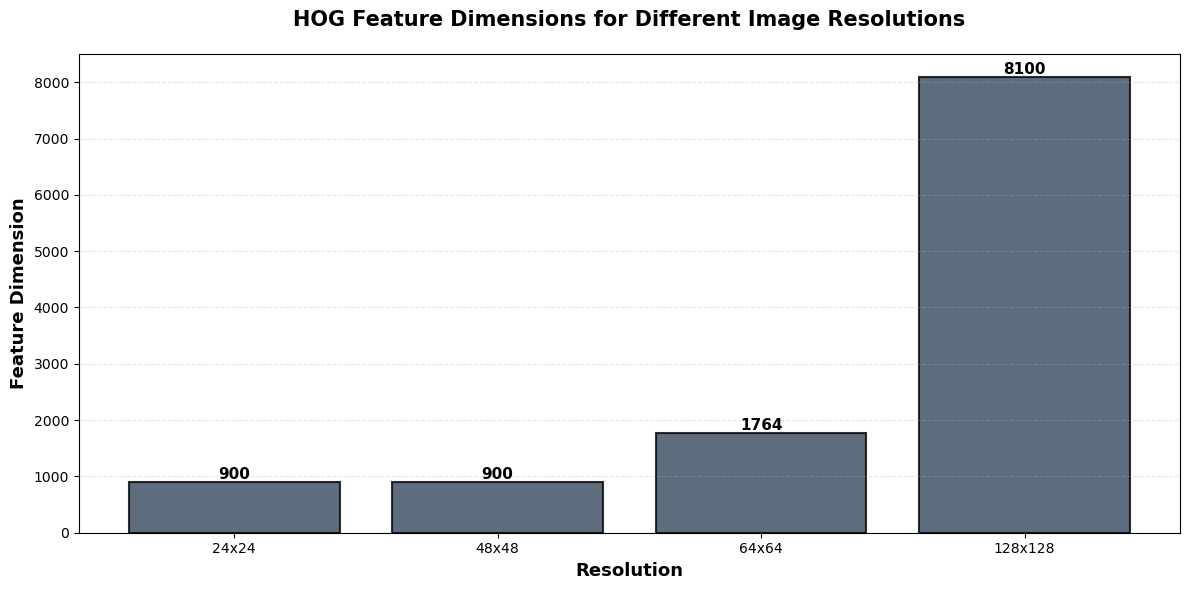

✓ Feature dimension comparison chart saved


In [10]:
# Extract feature dimensions
feature_dims = [r['feature_dim'] for r in results]

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(resolutions, feature_dims, color='#34495e', alpha=0.8, 
              edgecolor='black', linewidth=1.5)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Customize chart
ax.set_xlabel('Resolution', fontsize=13, fontweight='bold')
ax.set_ylabel('Feature Dimension', fontsize=13, fontweight='bold')
ax.set_title('HOG Feature Dimensions for Different Image Resolutions', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'feature_dimension_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature dimension comparison chart saved")

## 11. Identify Best Resolution

In [11]:
# Find best resolution based on test accuracy
best_result = max(results, key=lambda x: x['test_accuracy'])
best_resolution = best_result['resolution']

print("\n" + "="*80)
print("🏆 BEST RESOLUTION RECOMMENDATION")
print("="*80)
print(f"\nBest Resolution: {best_resolution}")
print("-" * 80)
print(f"Test Accuracy: {best_result['test_accuracy']*100:.2f}%")
print(f"Validation Accuracy: {best_result['validation_accuracy']*100:.2f}%")
print(f"Feature Dimension: {best_result['feature_dim']}")
print(f"Total Time: {best_result['total_time']:.2f} seconds")
print(f"Best Parameters: {best_result['best_params']}")

# Compare with other resolutions
print("\n" + "-" * 80)
print("Comparison with other resolutions:")
print("-" * 80)
for r in results:
    if r['resolution'] != best_resolution:
        acc_diff = (best_result['test_accuracy'] - r['test_accuracy']) * 100
        time_diff = best_result['total_time'] - r['total_time']
        print(f"{r['resolution']:8s}: {acc_diff:+.2f}% accuracy difference, {time_diff:+.2f}s time difference")

print("\n" + "="*80)

# Save best resolution info
best_info_path = os.path.join(RESULTS_PATH, 'best_resolution.txt')
with open(best_info_path, 'w') as f:
    f.write(f"Best Resolution: {best_resolution}\n")
    f.write(f"Test Accuracy: {best_result['test_accuracy']*100:.2f}%\n")
    f.write(f"Validation Accuracy: {best_result['validation_accuracy']*100:.2f}%\n")
    f.write(f"Feature Dimension: {best_result['feature_dim']}\n")
    f.write(f"Best Parameters: {best_result['best_params']}\n")

print(f"✓ Best resolution info saved to: {best_info_path}")


🏆 BEST RESOLUTION RECOMMENDATION

Best Resolution: 48x48
--------------------------------------------------------------------------------
Test Accuracy: 73.89%
Validation Accuracy: 75.12%
Feature Dimension: 900
Total Time: 53.65 seconds
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

--------------------------------------------------------------------------------
Comparison with other resolutions:
--------------------------------------------------------------------------------
24x24   : +1.03% accuracy difference, -1.97s time difference
64x64   : +0.83% accuracy difference, -59.62s time difference
128x128 : +7.48% accuracy difference, -1251.45s time difference

✓ Best resolution info saved to: /media/ubuntu/NVME/AIML project/AlphaNum2results/SVMhog/resolution_comparison/best_resolution.txt


## 12. Detailed Analysis - Accuracy vs Time Trade-off

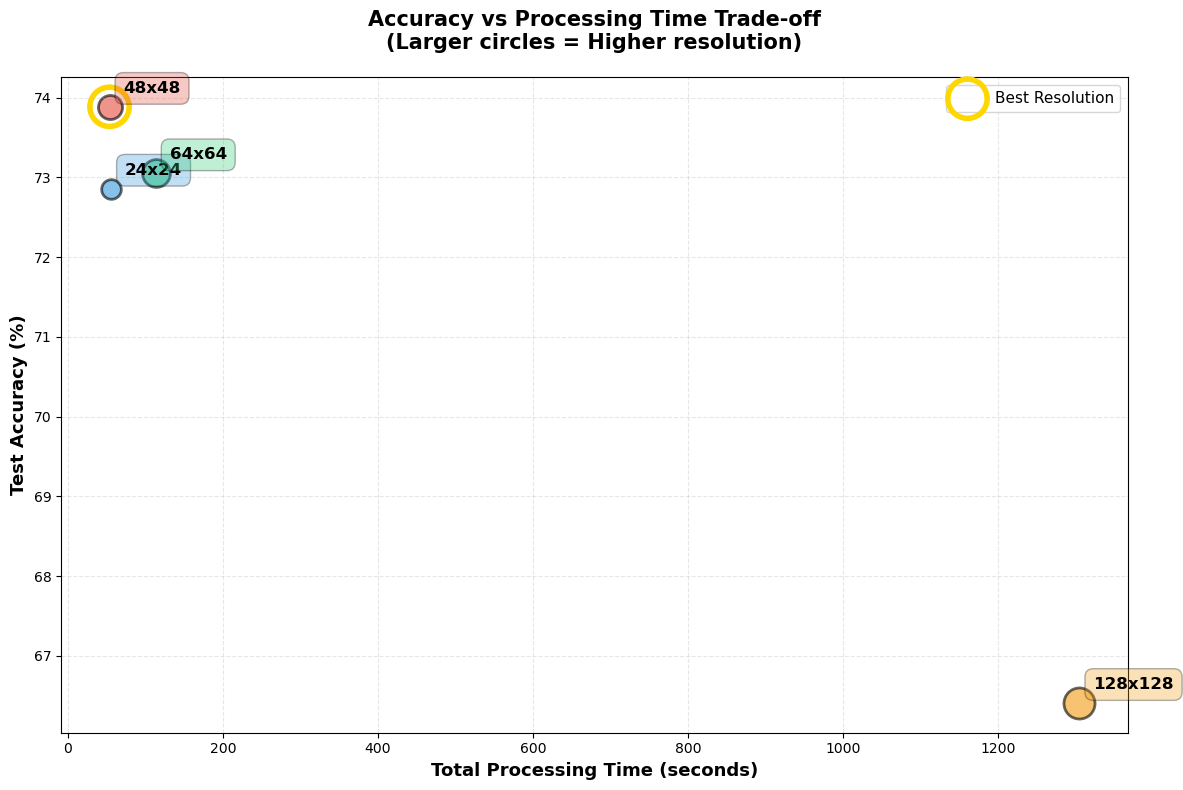

✓ Accuracy vs Time trade-off chart saved


In [12]:
# Create scatter plot showing accuracy vs time trade-off
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each resolution
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
sizes = [200, 300, 400, 500]

for i, r in enumerate(results):
    ax.scatter(r['total_time'], r['test_accuracy']*100, 
              s=sizes[i], alpha=0.6, color=colors[i], 
              edgecolors='black', linewidth=2)
    ax.annotate(r['resolution'], 
               xy=(r['total_time'], r['test_accuracy']*100),
               xytext=(10, 10), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3))

# Highlight best resolution
ax.scatter(best_result['total_time'], best_result['test_accuracy']*100,
          s=800, facecolors='none', edgecolors='gold', linewidth=4,
          label='Best Resolution')

# Customize chart
ax.set_xlabel('Total Processing Time (seconds)', fontsize=13, fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Accuracy vs Processing Time Trade-off\n(Larger circles = Higher resolution)', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'accuracy_vs_time_tradeoff.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Accuracy vs Time trade-off chart saved")

## 13. Final Recommendations

In [13]:
print("\n" + "="*80)
print("📋 FINAL RECOMMENDATIONS")
print("="*80)

# Sort by test accuracy
sorted_results = sorted(results, key=lambda x: x['test_accuracy'], reverse=True)

print("\n1️⃣ Best Overall Accuracy:")
print(f"   Resolution: {sorted_results[0]['resolution']}")
print(f"   Test Accuracy: {sorted_results[0]['test_accuracy']*100:.2f}%")

# Sort by efficiency (accuracy per second)
for r in results:
    r['efficiency'] = r['test_accuracy'] / r['total_time']
sorted_by_efficiency = sorted(results, key=lambda x: x['efficiency'], reverse=True)

print("\n2️⃣ Best Efficiency (Accuracy per Second):")
print(f"   Resolution: {sorted_by_efficiency[0]['resolution']}")
print(f"   Efficiency: {sorted_by_efficiency[0]['efficiency']*100:.4f}% per second")
print(f"   Test Accuracy: {sorted_by_efficiency[0]['test_accuracy']*100:.2f}%")
print(f"   Total Time: {sorted_by_efficiency[0]['total_time']:.2f} seconds")

# Sort by fastest
sorted_by_time = sorted(results, key=lambda x: x['total_time'])

print("\n3️⃣ Fastest Processing:")
print(f"   Resolution: {sorted_by_time[0]['resolution']}")
print(f"   Total Time: {sorted_by_time[0]['total_time']:.2f} seconds")
print(f"   Test Accuracy: {sorted_by_time[0]['test_accuracy']*100:.2f}%")

print("\n" + "-" * 80)
print("💡 Usage Recommendations:")
print("-" * 80)
print(f"• For PRODUCTION (highest accuracy): Use {sorted_results[0]['resolution']}")
print(f"• For REAL-TIME (fastest): Use {sorted_by_time[0]['resolution']}")
print(f"• For BALANCED (efficiency): Use {sorted_by_efficiency[0]['resolution']}")
print("\n" + "="*80)


📋 FINAL RECOMMENDATIONS

1️⃣ Best Overall Accuracy:
   Resolution: 48x48
   Test Accuracy: 73.89%

2️⃣ Best Efficiency (Accuracy per Second):
   Resolution: 48x48
   Efficiency: 1.3772% per second
   Test Accuracy: 73.89%
   Total Time: 53.65 seconds

3️⃣ Fastest Processing:
   Resolution: 48x48
   Total Time: 53.65 seconds
   Test Accuracy: 73.89%

--------------------------------------------------------------------------------
💡 Usage Recommendations:
--------------------------------------------------------------------------------
• For PRODUCTION (highest accuracy): Use 48x48
• For REAL-TIME (fastest): Use 48x48
• For BALANCED (efficiency): Use 48x48



## 📝 Summary

This notebook compared SVM with HOG features across different image resolutions:

### What We Did:
1. **Extracted HOG features** for 4 different resolutions (24x24, 48x48, 64x64, 128x128)
2. **Trained SVM models** with GridSearchCV for optimal hyperparameters
3. **Evaluated performance** on train, validation, and test sets
4. **Compared results** across accuracy, time, and feature dimensions
5. **Identified best resolution** for different use cases

### Key Insights:
- **Higher resolution** doesn't always mean better accuracy
- **Feature dimension** increases with resolution (more computation)
- **Trade-off** between accuracy and processing time
- **Optimal resolution** balances accuracy and efficiency

### Files Generated:
- `resolution_comparison_results.csv` - Detailed results table
- `accuracy_comparison.png` - Accuracy comparison chart
- `time_comparison.png` - Processing time comparison
- `feature_dimension_comparison.png` - Feature dimension comparison
- `accuracy_vs_time_tradeoff.png` - Accuracy vs time scatter plot
- `best_resolution.txt` - Best resolution recommendation
- `svm_model_{resolution}.joblib` - Trained models for each resolution

### Next Steps:
1. Use the best resolution model for production
2. Update prediction notebooks to use optimal resolution
3. Consider ensemble methods combining multiple resolutions
4. Test on more diverse datasets to validate findings